In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import numpy as np
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as cal
import math

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define constants (replace these with actual values)
class Constants:
    initial_fixing_date = "2023-04-27"
    final_fixing_date = pd.to_datetime("2024-07-30")
    initialS1 = 524.60  # Initial price of Asset 1 (e.g., Lonza)
    initialS2 = 271.60  # Initial price of Asset 2 (e.g., Sika)
    barrierS1 = 329.76
    barrierS2 = 144.24
    V0_S1 = 0.01        # Initial variance of Asset 1
    V0_S2 = 0.195311        # Initial variance of Asset 2
    mu_S1 = 0.018        # Expected return of Asset 1
    mu_S2 = 0.018        # Expected return of Asset 2
    kappa_S1 = 4.483091      # Mean reversion rate of Asset 1
    kappa_S2 = 0.901516      # Mean reversion rate of Asset 2
    theta_S1 = 0.124813     # Long-term variance of Asset 1
    theta_S2 = 0.184639     # Long-term variance of Asset 2
    sigma_v_S1 = 1    # Volatility of variance of Asset 1
    sigma_v_S2 = 0.549895   # Volatility of variance of Asset 2
    rho_S1 = 0.772476       # Correlation between asset price and variance of Asset 1
    rho_S2 = -0.728402       # Correlation between asset price and variance of Asset 2
    rho_assets = np.array([[1.0, 0.4250732997428952], [0.4250732997428952, 1.0]])  # Correlation between assets

cs = Constants()

class Dates:
    def get_early_observation_dates(self,initialdate, enddate):
        # Define the SIX exchange calendar
        six_cal = cal.get_calendar('SIX')

        # Calculate the first observation date
        first_observation_date = initialdate + pd.DateOffset(months=6)

        # Generate the date range with quarterly frequency
        redemption_dates = pd.date_range(start=first_observation_date, end=enddate)

        # Filter the dates to include only trading days
        trading_days = six_cal.valid_days(start_date=first_observation_date, end_date=enddate)
        redemption_dates = [date for date in redemption_dates if date in trading_days]

        #Make dates timezone naive
        redemption_dates = [date.tz_localize(None) for date in redemption_dates]

        return redemption_dates


    def num_business_days(self,startdate, enddate):
        #converting dates to timezone naive
        startdate = pd.Timestamp(startdate).tz_localize(None)
        enddate = pd.Timestamp(enddate).tz_localize(None)
        swiss_cal = cal.get_calendar("SIX")
        n_busi_days = len(swiss_cal.valid_days(startdate, enddate))
        return n_busi_days


    def add_business_days(self, date: pd.Timestamp):
        # Get the valid trading days starting from the next day
        six_cal = cal.get_calendar('SIX')
        valid_days = six_cal.valid_days(start_date=date + pd.tseries.offsets.BusinessDay(1), end_date=date + pd.Timedelta(days=10))

        # Return the first valid day
        return valid_days[0]

    def get_list_dates(self, startdate: pd.Timestamp, enddate: pd.Timestamp):

        # Define the SIX exchange calendar
        six_cal = cal.get_calendar('SIX')

        # Get the valid trading days between the start and end dates
        trading_days = six_cal.valid_days(start_date=startdate, end_date=enddate)

        # Make dates timezone naive
        date_list = [date.tz_localize(None) for date in trading_days]

        return date_list


    def business_days_in_quarter(self, start_date: pd.Timestamp, end_date: pd.Timestamp):
        # Define the SIX exchange calendar
        six_cal = cal.get_calendar('SIX')

        # Get the valid trading days between the start and end dates
        trading_days = six_cal.valid_days(start_date=start_date, end_date=end_date)

        # Make dates timezone naive
        trading_days = trading_days.tz_localize(None)

        # Count the number of business days
        num_business_days = len(trading_days)

        return num_business_days

dates = Dates()

# Load actual price data for Lonza (Asset 1)
lonza_price_df = pd.read_csv('C:/Users/javie/MH4518/lonza_price_60.csv')
# Load actual price data for Sika (Asset 2)
sika_price_df = pd.read_csv('C:/Users/javie/MH4518/sika_price_60.csv')
# For Lonza
lonza_price_df['Date'] = pd.to_datetime(lonza_price_df['Date'],format = '%m/%d/%y')
lonza_price_df.set_index('Date', inplace=True)
lonza_price_df.rename(columns={'Adj Close': 'S1'}, inplace=True)
# For Sika
sika_price_df['Date'] = pd.to_datetime(sika_price_df['Date'],format = '%m/%d/%y')
sika_price_df.set_index('Date', inplace=True)
sika_price_df.rename(columns={'Adj Close': 'S2'}, inplace=True)
# Keep only the 'S1' column for Lonza and 'S2' column for Sika
lonza_price_df = lonza_price_df[['S1']]
sika_price_df = sika_price_df[['S2']]
# Combine the two DataFrames on the Date index
actual_prices_df = lonza_price_df.join(sika_price_df, how='inner')
# Combine the two DataFrames on the Date index
actual_prices_df = lonza_price_df.join(sika_price_df, how='inner')
last_60_days = lonza_price_df.index[-60:]
# Convert each element to a date object (list of dates)
last_60_days = pd.to_datetime(last_60_days)


num_simulations = 1000
num_days = len(last_60_days)
num_assets = 2  # Two assets


# Initialize matrices to store the simulation results
simulated_prices_S1 = np.zeros((num_simulations, num_days))
simulated_prices_S2 = np.zeros((num_simulations, num_days))

# Heston model parameters
S0_original = [cs.initialS1, cs.initialS2]  # Initial prices
V0_original = [cs.V0_S1, cs.V0_S2]          # Initial variances
mu = [cs.mu_S1, cs.mu_S2]                   # Expected returns
kappa = [cs.kappa_S1, cs.kappa_S2]          # Mean reversion rates
theta = [cs.theta_S1, cs.theta_S2]          # Long-term variance levels
sigma_v = [cs.sigma_v_S1, cs.sigma_v_S2]    # Volatility of variance
rho = [cs.rho_S1, cs.rho_S2]                # Correlation between asset price and variance
rho_assets = cs.rho_assets                  # Correlation matrix between the two assets

dt = 1 / 252  # Daily time step

def simulate_heston_multidim(S0, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, nsims):
    num_assets = len(S0)
    # Initialize arrays
    S = np.zeros((nsims, N, num_assets))
    V = np.zeros((nsims, N, num_assets))

    # Set initial values
    S[:, 0, :] = S0
    V[:, 0, :] = V0

    # Cholesky decomposition for price and volatilities
    corr_matrix = np.block([
        [rho_assets, np.zeros((num_assets, num_assets))],
        [np.zeros((num_assets, num_assets)), np.eye(num_assets)]
    ])
    L = np.linalg.cholesky(corr_matrix)

    for t in range(1, N):
        Z = np.random.normal(size=(2 * num_assets, nsims))
        dW = L @ Z * np.sqrt(dt)  # Shape: (2 * num_assets, nsims)

        for i in range(num_assets):
            dW_S_i = dW[i, :]
            dW_v_i = dW[num_assets + i, :]
            dW_v_i = rho[i] * dW_S_i + np.sqrt(1 - rho[i] ** 2) * dW_v_i

            V_prev = V[:, t - 1, i]
            V_sqrt = np.sqrt(np.maximum(V_prev, 0))
            V[:, t, i] = V_prev + kappa[i] * (theta[i] - V_prev) * dt + sigma_v[i] * V_sqrt * dW_v_i
            V[:, t, i] = np.maximum(V[:, t, i], 0)

            S_prev = S[:, t - 1, i]
            S[:, t, i] = S_prev * np.exp((mu[i] - 0.5 * V_prev) * dt + V_sqrt * dW_S_i)

    return S, V

# Initialize a list to store full price paths for the first 5 days
full_price_paths_S1 = []
full_price_paths_S2 = []
full_dates = []

# Loop over each trading day
for day_idx, current_date in enumerate(last_60_days):
    logging.info(f'Simulating from day {day_idx + 1}/{num_days} ({current_date.date()})')

    # Remaining days from current date
    remaining_days = last_60_days[last_60_days >= current_date]
    N = len(remaining_days)

    # Use initial prices (you can update S0 if you have observed prices on current_date)
    try:
        # Extract actual prices for current_date
        S0 = [
            actual_prices_df.loc[current_date, 'S1'],
            actual_prices_df.loc[current_date, 'S2']
        ]
    except KeyError:
        # Handle the case where the current_date is not in actual_prices_df
        logging.warning(f"No actual prices found for {current_date.date()}, using original S0.")
        S0 = S0_original
    V0 = V0_original  # If you have updated V0 for each day, update it here

    # Skip if no remaining days
    if N <= 0:
        continue

    # Simulate paths from the current day
    S_simulated, _ = simulate_heston_multidim(S0, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations)

    # Store the first simulated prices (for the current day)
    simulated_prices_S1[:, day_idx] = S_simulated[:, 0, 0]
    simulated_prices_S2[:, day_idx] = S_simulated[:, 0, 1]

    # For the first 60 days, store the full price paths
    if day_idx < 61:
        full_price_paths_S1.append(S_simulated[:, :, 0])
        full_price_paths_S2.append(S_simulated[:, :, 1])
        full_dates.append(remaining_days)

df_S1 = pd.DataFrame(full_price_paths_S1[58])
print(df_S1)
terminal_price_lonza = df_S1[1]
print(terminal_price_lonza)

df_S2 = pd.DataFrame(full_price_paths_S2[58])
print(df_S2)
terminal_price_sika = df_S2[1]
print(terminal_price_sika)

#payoff function
def payoff(paths1, paths2, params, fdos):
    """
        Calculates the payoff for each simulation based on the product conditions.

        Params:
            paths1: DataFrame of simulated paths for Lonza (columns: simulations)
            paths2: DataFrame of simulated paths for Sika (columns: simulations)
            params: Dictionary containing product parameters
            fdos: First date of simulation (pricing date)

        Returns:
            payoffs: Array of payoffs for each simulation
        """

    def get_number_of_coupon_periods(start_date, end_date, frequency='quarterly'):
        delta = relativedelta(end_date, start_date)
        if frequency == 'quarterly':
            periods = delta.years * 4 + delta.months // 3
        elif frequency == 'monthly':
            periods = delta.years * 12 + delta.months
        else:
            periods = delta.years  # Assuming annual
        return periods

    def checkbarrier(lonza, sika, barrierS1, barrierS2):
        # Assuming daily monitoring
        barrier_breach = ((lonza <= barrierS1) | (sika <= barrierS2)).any()
        return barrier_breach

    def check_terminal(lonza, sika, initialS1, initialS2):
        terminal_condition = (lonza.iloc[-1] < initialS1) or (sika.iloc[-1] < initialS2)
        return terminal_condition

    # Ensure columns are sorted if necessary
    paths1 = paths1.reindex(sorted(paths1.columns), axis=1)
    paths2 = paths2.reindex(sorted(paths2.columns), axis=1)
    simulations = paths1.columns  # List of simulation names

    payoffs = []

    for sim_name in simulations:
        early_redeem = False
        lonza = paths1[sim_name]
        sika = paths2[sim_name]
        early_observation_dates = dates.get_early_observation_dates(pd.Timestamp('2024-04-30'), cs.final_fixing_date)

        for date_idx, t_date in enumerate(early_observation_dates):
            if (lonza.loc[t_date] >= cs.initialS1) and (sika.loc[t_date] >= cs.initialS2):
                # Early redemption
                settlement_delay = params.get('Settlement_Delay', 2)
                early_redemption_date = dates.add_business_days(t_date, settlement_delay)
                periods = get_number_of_coupon_periods(fdos, early_redemption_date)
                payoff_value = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
                payoffs.append(payoff_value)
                early_redeem = True
                break  # Exit the early observation loop

        if not early_redeem:
            barrierhit = checkbarrier(lonza, sika, cs.barrierS1, cs.barrierS2)
            terminallower = check_terminal(lonza, sika, cs.initialS1, cs.initialS2)

            if not barrierhit and not terminallower:  # Best case scenario
                periods = get_number_of_coupon_periods(pd.Timestamp('2024-04-30'), cs.final_fixing_date)
                payoff_value = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
                payoffs.append(payoff_value)
            else:
                # Worst-case scenario
                perf_lonza = lonza.iloc[-1] / cs.initialS1
                perf_sika = sika.iloc[-1] / cs.initialS2
                worse_perf = min(perf_lonza, perf_sika)
                periods = get_number_of_coupon_periods(pd.Timestamp('2024-04-30'), cs.final_fixing_date)
                payoff_value = params['Denomination'] * worse_perf
                payoff_value += params['Denomination'] * params['Coupon_Rate'] * periods
                payoffs.append(payoff_value)

    payoffs = np.array(payoffs)
    return payoffs

# Initialize variables
payoffs_list = []
params = {'Denomination': 1000, 'Coupon_Rate': 0.02}
fdos = last_60_days[0]
batch_size = num_simulations  # Number of simulations per day

# # Loop over each day
# for day_idx in range(len(full_price_paths_S1)):
#     batch_start_idx = day_idx * batch_size
#     sim_indices = range(batch_start_idx, batch_start_idx + batch_size)

#     # Get the simulated paths for S1 and S2
#     paths_S1_array = full_price_paths_S1[day_idx]
#     paths_S2_array = full_price_paths_S2[day_idx]

#     # Transpose the arrays to create DataFrames
#     paths_S1_df = pd.DataFrame(paths_S1_array.T)
#     paths_S2_df = pd.DataFrame(paths_S2_array.T)

#     # Set the index to the dates for the current simulation
#     dates_for_simulation = full_dates[day_idx]
#     paths_S1_df.index = dates_for_simulation
#     paths_S2_df.index = dates_for_simulation

#     # Assign simulation indices to the columns
#     paths_S1_df.columns = sim_indices
#     paths_S2_df.columns = sim_indices

#     # Call the payoff function
#     payoffs = payoff(paths_S1_df, paths_S2_df, params, last_60_days[day_idx])
#     # Store the payoffs
#     payoffs_list.append(payoffs)

# df_payoff = pd.DataFrame(payoffs_list)

# # Assuming you have all 90 rows, here we just demonstrate with first 5
# r = 0.018

# # Create a 'Day' column representing the number of days since the first day
# df_payoff['Day'] = df_payoff.index  # Assuming row 0 is Day 0

# # Convert days to years
# df_payoff['Time_in_Years'] = df_payoff['Day'] / 365

# # Calculate the discount factor using continuous discounting
# df_payoff['Discount_Factor'] = np.exp(-r * df_payoff['Time_in_Years'])

# # Specify the columns to discount
# columns_to_discount = list(range(batch_size))
# # Create a copy of the DataFrame to store discounted values
# df_discounted = df_payoff.copy()
# # Apply the discount factor
# df_discounted[columns_to_discount] = df_payoff[columns_to_discount].multiply(df_payoff['Discount_Factor'], axis=0)

# df_discounted = df_discounted.drop(columns=['Day', 'Time_in_Years', 'Discount_Factor'])

# df_payoff['avg_payoff'] = df_discounted.mean(axis=1)
# avg_payoff = df_payoff['avg_payoff']

# Historical Data provided
data = [
    {"date": "2024-07-30", "value": 990.9},
    {"date": "2024-07-29", "value": 991.1},
    {"date": "2024-07-26", "value": 991.5},
    {"date": "2024-07-25", "value": 985.6},
    {"date": "2024-07-24", "value": 940.1},
    {"date": "2024-07-23", "value": 937.8},
    {"date": "2024-07-22", "value": 924.6},
    {"date": "2024-07-19", "value": 915.3},
    {"date": "2024-07-18", "value": 931.4},
    {"date": "2024-07-17", "value": 918.8},
    {"date": "2024-07-16", "value": 927.5},
    {"date": "2024-07-15", "value": 930.4},
    {"date": "2024-07-12", "value": 933.5},
    {"date": "2024-07-11", "value": 937.2},
    {"date": "2024-07-10", "value": 920.5},
    {"date": "2024-07-09", "value": 912.2},
    {"date": "2024-07-08", "value": 908.1},
    {"date": "2024-07-05", "value": 907.7},
    {"date": "2024-07-04", "value": 901.7},
    {"date": "2024-07-03", "value": 898.6},
    {"date": "2024-07-02", "value": 879.9},
    {"date": "2024-07-01", "value": 884.1},
    {"date": "2024-06-28", "value": 887.5},
    {"date": "2024-06-27", "value": 881.2},
    {"date": "2024-06-26", "value": 880.8},
    {"date": "2024-06-25", "value": 876.5},
    {"date": "2024-06-24", "value": 882},
    {"date": "2024-06-21", "value": 865.5},
    {"date": "2024-06-20", "value": 871.1},
    {"date": "2024-06-19", "value": 858.6},
    {"date": "2024-06-18", "value": 864.7},
    {"date": "2024-06-17", "value": 857.3},
    {"date": "2024-06-14", "value": 870.5},
    {"date": "2024-06-13", "value": 872.9},
    {"date": "2024-06-12", "value": 879.2},
    {"date": "2024-06-11", "value": 896},
    {"date": "2024-06-06", "value": 911.3},
    {"date": "2024-06-05", "value": 896},
    {"date": "2024-06-04", "value": 880.2},
    {"date": "2024-06-03", "value": 882.7},
    {"date": "2024-05-31", "value": 882.9},
    {"date": "2024-05-30", "value": 884.6},
    {"date": "2024-05-29", "value": 883.8},
    {"date": "2024-05-28", "value": 918.2},
    {"date": "2024-05-27", "value": 923},
    {"date": "2024-05-24", "value": 925.8},
    {"date": "2024-05-23", "value": 918.3},
    {"date": "2024-05-22", "value": 919.2},
    {"date": "2024-05-21", "value": 942.2},
    {"date": "2024-05-17", "value": 942.4},
    {"date": "2024-05-16", "value": 941.5},
    {"date": "2024-05-15", "value": 929},
    {"date": "2024-05-14", "value": 904.4},
    {"date": "2024-05-13", "value": 922.5},
    {"date": "2024-05-10", "value": 930.8},
    {"date": "2024-05-08", "value": 929.8},
    {"date": "2024-05-07", "value": 921.7},
    {"date": "2024-05-06", "value": 921.6},
    {"date": "2024-05-03", "value": 921.1},
    {"date": "2024-05-02", "value": 919.5},
    {"date": "2024-04-30", "value": 909.6}
]

# Create DataFrame
df = pd.DataFrame(data)
df.sort_values(by='date', inplace=True)
df['date'] = pd.to_datetime(df['date'])

# # Combined plot of realized and simulated payoffs
# plt.figure(figsize=(12, 6))
# # Plotting the realized payoff
# plt.plot(df['date'], df['value'], linestyle='-', color='blue', label="Realized Payoff")
# # Plotting the simulated payoff
# plt.plot(lonza_price_df.index, avg_payoff, linestyle='-', color='orange', label="Simulated Payoff")
# # Adding title and labels
# plt.title("Realized and Simulated Payoffs Over Time")
# plt.xlabel("Date")
# plt.ylabel("Value")
# plt.legend()
# # Display grid and format
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

2024-11-13 11:09:04,037 - INFO - Simulating from day 1/60 (2024-04-30)
2024-11-13 11:09:04,048 - INFO - Simulating from day 2/60 (2024-05-01)
2024-11-13 11:09:04,057 - INFO - Simulating from day 3/60 (2024-05-02)
2024-11-13 11:09:04,065 - INFO - Simulating from day 4/60 (2024-05-03)
2024-11-13 11:09:04,073 - INFO - Simulating from day 5/60 (2024-05-07)
2024-11-13 11:09:04,081 - INFO - Simulating from day 6/60 (2024-05-08)
2024-11-13 11:09:04,089 - INFO - Simulating from day 7/60 (2024-05-10)
2024-11-13 11:09:04,097 - INFO - Simulating from day 8/60 (2024-05-13)
2024-11-13 11:09:04,105 - INFO - Simulating from day 9/60 (2024-05-14)
2024-11-13 11:09:04,112 - INFO - Simulating from day 10/60 (2024-05-15)
2024-11-13 11:09:04,120 - INFO - Simulating from day 11/60 (2024-05-16)
2024-11-13 11:09:04,128 - INFO - Simulating from day 12/60 (2024-05-17)
2024-11-13 11:09:04,136 - INFO - Simulating from day 13/60 (2024-05-21)
2024-11-13 11:09:04,144 - INFO - Simulating from day 14/60 (2024-05-22)
2

         0           1
0    572.0  572.610202
1    572.0  567.522444
2    572.0  571.492818
3    572.0  574.095884
4    572.0  567.322192
..     ...         ...
995  572.0  569.521026
996  572.0  569.936669
997  572.0  578.039512
998  572.0  568.455554
999  572.0  571.766034

[1000 rows x 2 columns]
0      572.610202
1      567.522444
2      571.492818
3      574.095884
4      567.322192
          ...    
995    569.521026
996    569.936669
997    578.039512
998    568.455554
999    571.766034
Name: 1, Length: 1000, dtype: float64
              0           1
0    263.700012  264.554498
1    263.700012  257.740310
2    263.700012  261.588254
3    263.700012  272.327119
4    263.700012  252.606032
..          ...         ...
995  263.700012  273.198295
996  263.700012  256.123215
997  263.700012  261.628334
998  263.700012  256.264566
999  263.700012  267.296068

[1000 rows x 2 columns]
0      264.554498
1      257.740310
2      261.588254
3      272.327119
4      252.606032
          ..

In [2]:
# payoffs_new = []
# # Loop over each day
# for day_idx in range(len(full_price_paths_S1)):
#     batch_start_idx = day_idx * batch_size
#     sim_indices = range(batch_start_idx, batch_start_idx + batch_size)

#     # Get the simulated paths for S1 and S2
#     paths_S1_array = full_price_paths_S1[day_idx]
#     paths_S2_array = full_price_paths_S2[day_idx]

#     # Transpose the arrays to create DataFrames
#     paths_S1_df = pd.DataFrame(paths_S1_array.T)
#     paths_S2_df = pd.DataFrame(paths_S2_array.T)

#     # Set the index to the dates for the current simulation
#     dates_for_simulation = full_dates[day_idx]
#     paths_S1_df.index = dates_for_simulation
#     paths_S2_df.index = dates_for_simulation

#     # Assign simulation indices to the columns
#     paths_S1_df.columns = sim_indices
#     paths_S2_df.columns = sim_indices

#     # Call the payoff function
#     payoffs = payoff(paths_S1_df, paths_S2_df, params, last_60_days[day_idx])
    
#     payoffs_new.append(payoffs)

# df = pd.DataFrame(payoffs_new)
# print(df)

# payoffs_heston = df.mean(axis=0).tolist()

# Control Variate

In [2]:
# Define the single-asset Heston simulation function to use asset path as control variate
def simulate_heston_singledim(S0, V0, mu, kappa, theta, sigma_v, rho, N, dt, nsims):
    S = np.zeros((nsims, N))
    V = np.zeros((nsims, N))
    S[:, 0] = S0
    V[:, 0] = V0

    # Correlation matrix for single asset and variance process
    corr_matrix = np.eye(2)  # 2x2 identity matrix for single asset and variance process
    L = np.linalg.cholesky(corr_matrix)

    for t in range(1, N):
        Z = np.random.normal(size=(2, nsims))
        dW = L @ Z * np.sqrt(dt)

        # Separate dW components for asset price and variance process
        dW_S = dW[0, :]
        dW_v = rho * dW_S + np.sqrt(1 - rho ** 2) * dW[1, :]

        V_prev = V[:, t - 1]
        V_sqrt = np.sqrt(np.maximum(V_prev, 0))
        V[:, t] = V_prev + kappa * (theta - V_prev) * dt + sigma_v * V_sqrt * dW_v
        V[:, t] = np.maximum(V[:, t], 0)

        S_prev = S[:, t - 1]
        S[:, t] = S_prev * np.exp((mu - 0.5 * V_prev) * dt + V_sqrt * dW_S)

    return S, V

        
S1, V1 = simulate_heston_singledim(
    S0=cs.initialS1,
    V0=cs.V0_S1,
    mu=cs.mu_S1,
    kappa=cs.kappa_S1,
    theta=cs.theta_S1,
    sigma_v=cs.sigma_v_S1,
    rho=cs.rho_S1,
    N=60,
    dt=dt,
    nsims=100
)

# Get the terminal value of each path in the nested list S1
lonza_path_new_terminal = [path[-1] for path in S1.tolist()]

S2, V2 = simulate_heston_singledim(
    S0=cs.initialS2,
    V0=cs.V0_S2,
    mu=cs.mu_S2,
    kappa=cs.kappa_S2,
    theta=cs.theta_S2,
    sigma_v=cs.sigma_v_S2,
    rho=cs.rho_S2,
    N=60,
    dt=dt,
    nsims=100
)

# Get the terminal value of each path in the nested list S1
sika_path_new_terminal = [path[-1] for path in S1.tolist()]


In [19]:
def cv2(payoffs_heston, data: pd.DataFrame, orig_sim_asset, asset_type, new_terminal):
    '''
    Computes the control variate estimator using the provided payoffs and actual data.

    Params:
        payoffs_list (list or np.array): Simulated payoffs from the Heston model.
        data (pd.DataFrame): Actual price data.
        fdos: [Description needed for 'fdos']

    Returns:
        theta_CV (float): Control variate estimate of the payoff.
    '''

    # Computing Beta with initial set of Heston Simulations
    
    # Compute variances
    var_X = np.var(payoffs_heston, ddof=1)
    var_Y = np.var(orig_sim_asset, ddof=1)
    cov_matrix = np.cov(payoffs_heston, orig_sim_asset, ddof=1)
    cov_XY = cov_matrix[0, 1]
    
    # Compute correlation
    corr_XY = cov_XY / np.sqrt(var_X * var_Y)  
    print(f"Correlation between X and Y: {corr_XY:.4f}") 
    # Compute beta coefficient
    beta = cov_XY / var_Y
    print(f"Beta (β) Coefficient: {beta}")
    
    # Compute mean(X) and mean(Y) with new set of randomness
          
    # Compute means
    payoff_extra = payoff(pd.DataFrame(S1), pd.DataFrame(S2), params, fdos)
    mean_X = np.mean(payoff_extra)
    mean_Y = new_terminal
    E_Y = data[asset_type].mean()
    
    # Compute control variate estimator
    X_CV = mean_X + beta * (E_Y - mean_Y)
    theta_CV = np.mean(X_CV)
    
    # Compute variance reduction
    var_theta_CV = var_X - (cov_XY ** 2) / var_Y
    variance_reduction = (var_X - var_theta_CV) / var_X * 100
    print(f"Variance Reduction Achieved: {variance_reduction:.2f}%")
    print("CV Estimate Payoff :", theta_CV)
    print("RMSE :", np.sqrt(np.mean((payoffs_heston-theta_CV)**2)))
    
    return theta_CV

In [4]:
import yfinance as yfin

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data_indiv = getdata()

[*********************100%***********************]  2 of 2 completed


In [23]:
df_discounted2 = pd.read_csv('df_discounted2.csv')
df_discounted2 = df_discounted2.drop(df_discounted2.columns[-5:], axis=1)
df_discounted2 = df_discounted2.iloc[:, 1:]
payoffs_heston = df_discounted2.mean(axis=0).tolist()
payoff_cv2= cv2(payoffs_heston, data_indiv, terminal_price_lonza, 'LONN.SW', lonza_path_new_terminal)

Correlation between X and Y: -0.0563
Beta (β) Coefficient: -0.15960998181597252
Variance Reduction Achieved: 0.32%
CV Estimate Payoff : 842.3012162013364
RMSE : 65.89589852746494


# Risk Management

## Calculate Delta

In [31]:
h = 0.01
N = 60
S_plus_h = [cs.initialS1 + h*cs.initialS1, cs.initialS2 + h*cs.initialS1]
S_minus_h = [cs.initialS1 - h*cs.initialS2, cs.initialS2 - h*cs.initialS2]
    
# Simulate the paths using Heston for both perturbed prices
payoffs_plus_h = []
payoffs_minus_h = []
        
S_simulated_plus, _ = simulate_heston_multidim(S_plus_h, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations)
S_simulated_minus, _ = simulate_heston_multidim(S_minus_h, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations)

# Extract payoff for each perturbation
payoff_plus = payoff(pd.DataFrame(S_simulated_plus[:, :, 0]), pd.DataFrame(S_simulated_plus[:, :, 1]), params, last_60_days[0])
payoff_minus = payoff(pd.DataFrame(S_simulated_minus[:, :, 0]), pd.DataFrame(S_simulated_minus[:, :, 1]), params, last_60_days[0])

payoffs_plus_h.append(payoff_plus)
payoffs_minus_h.append(payoff_minus)

In [35]:
r = 0.018  # Discount rate
T = N / 252  # Time to maturity in years
discount_factor = np.exp(-r * T)
delta_lonza = discount_factor * (np.array(payoffs_plus_h) - np.array(payoffs_minus_h)) / (2 * (h*cs.initialS1))
delta_lonza = pd.DataFrame(delta_lonza)
delta_lonza = delta_lonza.T
delta_lonza = delta_lonza.iloc[::-1].reset_index(drop=True)

delta_sika = discount_factor * (np.array(payoffs_plus_h) - np.array(payoffs_minus_h)) / (2 * (h*cs.initialS2))
delta_sika = pd.DataFrame(delta_sika)
delta_sika = delta_sika.T
delta_sika = delta_sika.iloc[::-1].reset_index(drop=True)

In [37]:
print(delta_sika)

            0
0    8.539860
1    0.182456
2   -0.224313
3   -4.273763
4  -20.663121
5   -9.688131
6   -3.392283
7   12.780794
8   15.261632
9   30.540006
10  24.888603
11  28.603973
12  27.667402
13  27.630801
14  29.592308
15  27.752867
16  26.048466
17  25.757100
18  19.073551
19  22.048428
20  25.735464
21  13.775785
22  20.129595
23  19.863022
24  12.612419
25  13.423381
26  13.426401
27  20.094452
28  18.677865
29  15.886521
30  33.554763
31  34.337671
32  31.811394
33  35.759831
34  40.171543
35  41.275035
36  41.698618
37  35.096173
38  41.975617
39  37.160531
40  44.463771
41  45.931691
42  55.270271
43  53.430525
44  53.335029
45  43.817473
46  37.191663
47  36.198711
48  33.310770
49  29.494975
50  32.124555
51  31.462448
52  28.924355
53  26.774684
54  24.475494
55  15.014776
56  16.754105
57   7.696668
58   4.483190
59   1.833070


## Calculate Delta

In [220]:
# def calculate_delta(payoff_function, initial_price, h, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations, params):
#     # Simulate for S0 + h
#     S_plus_h = [initial_price[0] + h, initial_price[1] + h]
#     S_minus_h = [initial_price[0] - h, initial_price[1] - h]
    
#     # Simulate the paths using Heston for both perturbed prices
#     payoffs_plus_h = []
#     payoffs_minus_h = []
    
#     for i in range(num_simulations):
#         # Common random numbers for both simulations
#         S_simulated_plus, _ = simulate_heston_multidim(S_plus_h, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations)
#         S_simulated_minus, _ = simulate_heston_multidim(S_minus_h, V0, mu, kappa, theta, sigma_v, rho, rho_assets, N, dt, num_simulations)

#         # Extract payoff for each perturbation
#         payoff_plus = payoff_function(pd.DataFrame(S_simulated_plus[:, :, 0]), pd.DataFrame(S_simulated_plus[:, :, 1]), params, last_60_days[0])
#         payoff_minus = payoff_function(pd.DataFrame(S_simulated_minus[:, :, 0]), pd.DataFrame(S_simulated_minus[:, :, 1]), params, last_60_days[0])
        
#         payoffs_plus_h.append(payoff_plus)
#         payoffs_minus_h.append(payoff_minus)

#     # Calculate the Delta
#     r = 0.018  # Discount rate
#     T = N / 252  # Time to maturity in years
#     discount_factor = np.exp(-r * T)
    
#     delta = discount_factor * (np.mean(payoffs_plus_h, axis = 1) - np.mean(payoffs_minus_h, axis = 1)) / (2 * h)
    
#     return delta

# delta = calculate_delta(payoff, [cs.initialS1, cs.initialS2], h=0.01, V0=V0_original, mu=mu, kappa=kappa, theta=theta, sigma_v=sigma_v, 
#                         rho=rho, rho_assets=rho_assets, N=60, dt=dt, num_simulations=1, params=params)

# print("Estimated Delta:", delta)


Estimated Delta: [3978.00125778]


In [38]:
actual_product_price = pd.read_csv('C:/Users/javie/MH4518/product_price.csv')
# Sika

sika_price_df['interm_result_sika'] = delta_sika.values.flatten() * sika_price_df['S2'].values 
actual_product_price['portfolio_value_sika'] = actual_product_price['realized payoff'].values - sika_price_df['interm_result_sika'].values 

# Lonza
lonza_price_df['interm_result_lonza'] = delta_lonza.values.flatten() * lonza_price_df['S1'].values 
actual_product_price['portfolio_value_lonza'] = actual_product_price['realized payoff'].values - lonza_price_df['interm_result_lonza'].values

## Plot of Portfolio Value against Individual Asset Prices

### Sika

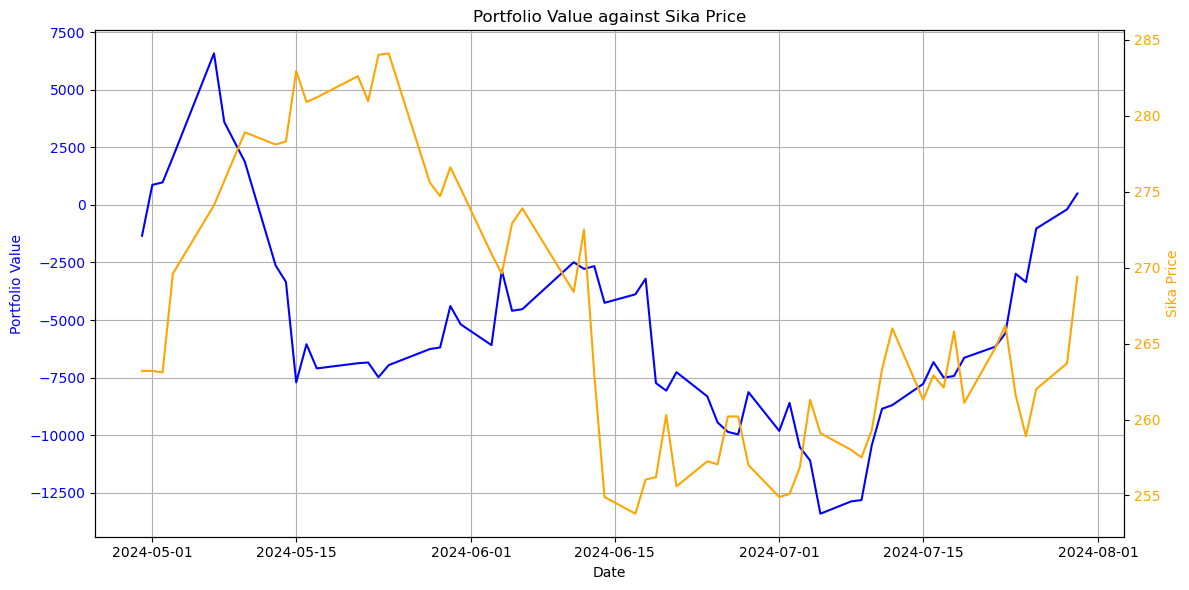

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the date columns to datetime objects (if they are not already)
actual_product_price['Date'] = pd.to_datetime(actual_product_price['Date'], format='%m/%d/%Y')

# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the portfolio value on the first y-axis
ax1.plot(actual_product_price['Date'], actual_product_price['portfolio_value_sika'], linestyle='-', color='blue', label="Portfolio Value")
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(sika_price_df.index, sika_price_df['S2'], linestyle='-', color='orange', label="Sika Price")
ax2.set_ylabel("Sika Price", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding title and grid
plt.title("Portfolio Value against Sika Price")
ax1.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Lonza

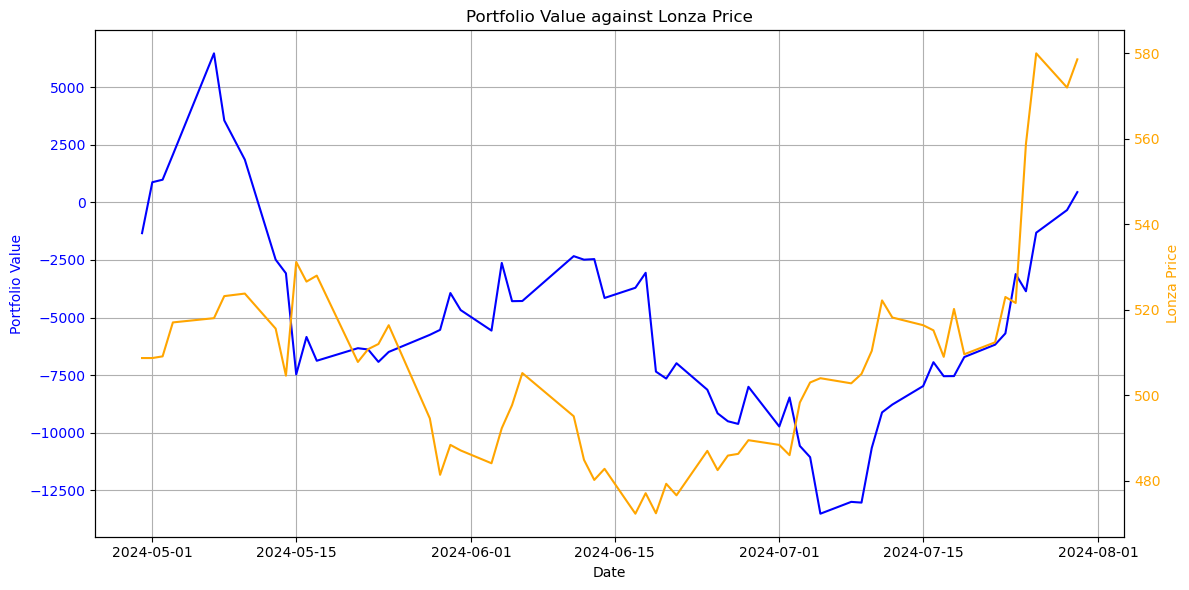

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the date columns to datetime objects (if they are not already)
actual_product_price['Date'] = pd.to_datetime(actual_product_price['Date'], format='%m/%d/%Y')

# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the portfolio value on the first y-axis
ax1.plot(actual_product_price['Date'], actual_product_price['portfolio_value_lonza'], linestyle='-', color='blue', label="Portfolio Value")
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(lonza_price_df.index, lonza_price_df['S1'], linestyle='-', color='orange', label="Lonza Price")
ax2.set_ylabel("Lonza Price", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding title and grid
plt.title("Portfolio Value against Lonza Price")
ax1.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
